In [0]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(input_):
  return 1 / (1 + np.exp(-input_))

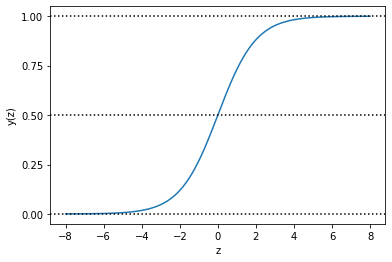

In [3]:
z = np.linspace(-8, 8, 1000)
y = sigmoid(z)

plt.plot(z, y)
plt.axhline(y = 0, ls = "dotted", color = 'k')
plt.axhline(y = 0.5, ls = "dotted", color = 'k')
plt.axhline(y = 1, ls = "dotted", color = 'k')
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
plt.xlabel('z')
plt.ylabel('y(z)')
plt.show()

In [5]:
from sklearn.feature_extraction import DictVectorizer
import pandas as pd

data = pd.read_csv('/content/drive/My Drive/Machine Learning/ctr-20000.csv')
data = data.drop(['id', 'hour', 'device_ip', 'device_id'], axis=1)

data_X = data.loc[ :, data.columns != 'click'].astype('str')
data_Y = data.loc[ :, data.columns == 'click'].astype('int').values.ravel()

train_X, test_X = data_X[0:15000], data_X[15000:]
train_Y, test_Y = data_Y[0:15000], data_Y[15000:]

dict_one_hot_encoder = DictVectorizer(sparse = False)
onehot_train_X = dict_one_hot_encoder.fit_transform(train_X.to_dict('records'))
onehot_test_X = dict_one_hot_encoder.transform(test_X.to_dict('records'))

print(train_X.shape)
print(onehot_train_X.shape)

(15000, 19)
(15000, 3244)


In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(fit_intercept = True, max_iter = 10000)
logistic_regression.fit(onehot_train_X, train_Y)

pos_prob = logistic_regression.predict_proba(onehot_test_X)[:, 1]
print("The ROC AUC testing set is: {:.3f}".format(roc_auc_score(test_Y, pos_prob)))

The ROC AUC testing set is: 0.710


In [9]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'eta0': [0.1, 0.01, 0.001]}

sdg_lr = SGDClassifier(loss = 'log', fit_intercept = True)

grid_search = GridSearchCV(sdg_lr, parameters, n_jobs = -1, cv = 3, scoring = 'roc_auc')

grid_search.fit(onehot_train_X, train_Y)

sdg_lr_best = grid_search.best_estimator_
pos_prob = sdg_lr_best.predict_proba(onehot_test_X)[:,1]
print("The ROC AUC testing set is: {:.3f}".format(roc_auc_score(test_Y, pos_prob)))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


The ROC AUC testing set is: 0.709


In [10]:
parameters = {'eta0': [0.1, 0.01, 0.001]}

sdg_lr = SGDClassifier(loss = 'log', fit_intercept = True, penalty='l1')

grid_search = GridSearchCV(sdg_lr, parameters, n_jobs = -1, cv = 3, scoring = 'roc_auc')

grid_search.fit(onehot_train_X, train_Y)

sdg_lr_best = grid_search.best_estimator_
pos_prob = sdg_lr_best.predict_proba(onehot_test_X)[:,1]
print("The ROC AUC testing set is: {:.3f}".format(roc_auc_score(test_Y, pos_prob)))

The ROC AUC testing set is: 0.704


In [11]:
parameters = {'eta0': [0.1, 0.01, 0.001]}

sdg_lr = SGDClassifier(loss = 'log', fit_intercept = True, penalty='l2')

grid_search = GridSearchCV(sdg_lr, parameters, n_jobs = -1, cv = 3, scoring = 'roc_auc')

grid_search.fit(onehot_train_X, train_Y)

sdg_lr_best = grid_search.best_estimator_
pos_prob = sdg_lr_best.predict_proba(onehot_test_X)[:,1]
print("The ROC AUC testing set is: {:.3f}".format(roc_auc_score(test_Y, pos_prob)))

The ROC AUC testing set is: 0.709


In [12]:
import nltk
nltk.download('names')
nltk.download('wordnet')

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer

all_names = set(names.words())
lemmatizer = WordNetLemmatizer()

def clean_text(docs):
  cleaned_docs = []
  for doc in docs:
    lemmatized_list = [lemmatizer.lemmatize(word.lower())\
                       for word in doc.split()\
                       if word.isalpha() and word not in all_names]
    cleaned_docs.append(' '.join(lemmatized_list))
  return cleaned_docs

In [14]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

data_train = fetch_20newsgroups(subset = 'train', categories = None, random_state = 42)
data_test = fetch_20newsgroups(subset = 'test', categories = None, random_state = 42)

cleaned_train = clean_text(data_train.data)
label_train = data_train.target

cleaned_test = clean_text(data_test.data)
label_test = data_test.target

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(sublinear_tf = True, max_df = 0.5, stop_words = 'english', max_features = 40000)

term_docs_train = tfidf_vectorizer.fit_transform(cleaned_train)
term_docs_test = tfidf_vectorizer.transform(cleaned_test)

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

parameters = {
    'penalty': ['l2', None],
    'alpha': [1e-07, 1e-06, 1e-05, 1e-04],
    'eta0': [0.01, 0.1, 1, 10]
}
sdg_lr = SGDClassifier(loss = 'log', learning_rate='constant', eta0=0.01, fit_intercept=True)
# SGD, sgd가 맞음
grid_search = GridSearchCV(sdg_lr, parameters, n_jobs=-1, cv = 3)
grid_search.fit(term_docs_train, label_train)
print(grid_search.best_params_)

{'alpha': 1e-06, 'eta0': 10, 'penalty': None}


In [17]:
sdg_lr_best = grid_search.best_estimator_
accuracy = sdg_lr_best.score(term_docs_test, label_test)
print(f'The accuracy on testing set is: {accuracy*100:.1f}%')

The accuracy on testing set is: 79.6%
